In [1]:
import os
import re
import spacy
import gensim
import random
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from datetime import datetime
from wordcloud import WordCloud
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from spacytextblob.spacytextblob import SpacyTextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

In [2]:
spacy_model = 'en_core_web_lg'

In [3]:
nlp = spacy.load(spacy_model)

In [4]:
cdxData = pd.read_csv('CDX Indices Matrix .csv', encoding='UTF-8')
tickerList = set(cdxData['Unnamed: 0'])
print(tickerList)  

{nan, 'ALCLCT-US', 'CHUBLIM', 'DHI', 'GE-CapCorp', 'GM-ResCLLC', 'DNY', 'GIS', 'DCEL', 'NAVILLC', 'TGRI-Ptnr', 'DISH-ESDBS', 'CBSCOR', 'DOMC', 'BGARIA', 'HAL', 'FO', 'CHILE', 'BAX', 'BWA', 'UNMG', 'QATAR', 'ALLYFI', 'CB', 'UHS', 'XRX', 'STZ', 'GE', 'LNC', 'MAY', 'MERIINC', 'ANDEAVAA', 'DIAMSPO', 'KBH', 'HOV', 'AV', 'NAV', 'PBI', 'CYH', 'PLCOAL', 'GM-ResCap', 'VENZ', 'CD-AvisBdgt', 'CVSCRM', 'HOV-K', 'KSS', 'XL', 'LYO', 'SAMSNG-Electron', 'POL', 'BEAMINC', 'BPLP', 'DD', 'AMD', 'CIB', 'CEG', 'HMT-LP', 'IAR', 'FDC', 'IRMD', 'SLR', 'MKHY-Energy', 'HRB-Fllc', 'ALTEL', 'VALPIT', 'HOWMAER', 'WFT', 'OVININC', 'CALIRES', 'R', 'TOY', 'TOL', 'SRV', 'OMAN', 'GPS', 'WMB', 'L', 'NEWEBRA', 'LVLT', 'PA-SPOT', 'SANM', 'AMT', 'GP', 'MYG', 'NEWALBS', 'RAI', 'THENEI', 'COX-CommInc', 'HOT', 'IHEAINC', 'CUM', 'DUKECO', 'PARAMGL', 'CIT', 'SBGI', 'ARM', 'FRCA', 'VMCo', 'AVP', 'CONABRA', 'LMLLC', 'DAL', 'VNO-LP', 'VIA', 'AES', 'AW-NorthAmerica', 'THC', 'TALEENE', 'HNTSMN-IntlLLC', 'RSH', 'DELBB-America', 'HILT

In [5]:
sp500Data = pd.read_csv('sandp500.csv', encoding='UTF-8')
spTickerList = set(sp500Data['Symbol'])
print(spTickerList)

{'ADSK', 'XLNX', 'RTX', 'SWKS', 'FTI', 'FITB', 'DHI', 'VNT', 'GIS', 'JBHT', 'SCHW', 'PSX', 'SLB', 'RE', 'DXCM', 'HAL', 'RL', 'ENPH', 'BAX', 'BWA', 'CB', 'UHS', 'XRX', 'STZ', 'GE', 'LNC', 'VRSK', 'PPG', 'SNA', 'ANSS', 'SYF', 'WAT', 'CHRW', 'EXR', 'VZ', 'AME', 'ZTS', 'WRB', 'CLX', 'LNT', 'OTIS', 'FMC', 'A', 'DFS', 'CF', 'IVZ', 'LIN', 'DD', 'NI', 'AMD', 'AAL', 'COST', 'HBAN', 'CRM', 'APTV', 'SYK', 'SBUX', 'INTU', 'ECL', 'PAYC', 'BIIB', 'DLTR', 'RSG', 'VTR', 'GPS', 'IPGP', 'L', 'TSLA', 'ROP', 'WMB', 'AMT', 'MSFT', 'NRG', 'EOG', 'CXO', 'ODFL', 'POOL', 'DAL', 'ETR', 'AES', 'VAR', 'SIVB', 'ICE', 'TRV', 'SRE', 'TSN', 'AAP', 'DTE', 'LKQ', 'FISV', 'CCI', 'ESS', 'LOW', 'COG', 'FLS', 'EW', 'NWL', 'LHX', 'ANTM', 'GPN', 'MHK', 'ZBH', 'FLIR', 'HIG', 'NTRS', 'LDOS', 'KR', 'MMC', 'EFX', 'ALL', 'HOLX', 'PWR', 'CTXS', 'MCD', 'ALXN', 'ABMD', 'PLD', 'TDG', 'NKE', 'AVY', 'EMR', 'ZION', 'CSX', 'DGX', 'SHW', 'HSIC', 'CPRT', 'MTB', 'SEE', 'VMC', 'WAB', 'FAST', 'AXP', 'CVX', 'LYV', 'VIAC', 'AIZ', 'PG', 'UPS', '

In [6]:
cdx_df = pd.read_excel("CDX Transposed by BICS.xlsx")
cdxTickerList = set(cdx_df['Stock Ticker'])
print(cdxTickerList)

{'CPB', 'RTX', 'IP', 'OVV', 'DHI', 'GIS', 'PG', 'UPS', 'D', 'LMT', 'HAL', 'BAX', 'BWA', 'CAT', 'CVS', 'GM', 'KMI', 'LNC', 'GE', 'EMN', 'TMUS', 'TRGP', 'HON', 'VZ', 'COF', 'JCI', 'VLO', 'ORCL', 'WHR', 'FDX', 'MSI', 'AGO', 'BBY', 'DELL', 'AMD', 'BRK.A', 'HPQ', 'PHM', 'DXC', 'SO', 'HES ', 'LEN', 'TECK', 'CSCO', 'R', 'UNH', 'TOL', 'AIG', 'FCX', 'NEE', 'WMB', 'GOLD', 'KHC', 'CTA-PA', 'BMY', 'ARW', 'BSX', 'EXPE', 'AVT', 'SPG', 'DOW', 'TRP', 'MPC', 'ENB ', 'AEP', 'CNQ', 'WMT', 'AES', 'PARA', 'NOC', 'CMCSA', 'TGT', 'MET ', 'AMGN', 'LUV', 'T', 'SRE', 'TSN', 'OMC', 'HD', 'DHR', 'AZO', 'CAG', 'DRI', 'MAR', 'LOW', 'MDLZ', 'DVN', 'NSC', 'EXC', 'BA', 'WY', 'RDN', 'PRU ', 'UNP', 'COP', 'KR', 'MCK', 'DE', 'HCA', 'NEM', 'HST', 'IBM', 'MCD', 'MDC', 'PFE', 'ALLY', 'CSX', 'MO', 'FENG', 'DGX', 'SHW', 'PKG', 'NRUC', 'CAH', 'ALL ', 'COXENT', 'JNJ', 'DIS'}


In [7]:
# find matches in Sp500 and CDX
matches = []
for ticker in tickerList:
    if ticker in spTickerList and ticker in cdxTickerList:
        matches.append(ticker)
matches_sorted = sorted(matches)
print(matches_sorted)
match_count = len(matches)
print(f"match count: {match_count}")

['AEP', 'AES', 'AIG', 'AMD', 'AMGN', 'AZO', 'BA', 'BAX', 'BBY', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CMCSA', 'COF', 'COP', 'CPB', 'CSCO', 'CSX', 'CVS', 'D', 'DE', 'DGX', 'DHI', 'DHR', 'DIS', 'DOW', 'DRI', 'DVN', 'EMN', 'EXC', 'FCX', 'FDX', 'GE', 'GIS', 'GM', 'HAL', 'HCA', 'HD', 'HON', 'HPQ', 'IBM', 'IP', 'JCI', 'JNJ', 'KR', 'LEN', 'LMT', 'LNC', 'LOW', 'LUV', 'MAR', 'MCD', 'MCK', 'MO', 'NEM', 'NOC', 'NSC', 'OMC', 'PFE', 'PG', 'PHM', 'SHW', 'SO', 'SRE', 'T', 'TGT', 'TSN', 'UNH', 'UNP', 'UPS', 'VLO', 'WHR', 'WMB', 'WMT', 'WY']
match count: 78


In [8]:
folder_path = 'transcripts/sandp500'  # path to text files
#file_contents = [] # for TF-IDF conversion
data = []  # List to store the data for DataFrame

# Regular expression pattern for extracting date
pattern = r'(?i)(January|February|March|April|May|June|July|August|September|October|November|December)\s+(\d{1,2}),\s*(\d{4})'

for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):  # Consider only text files
        file_path = os.path.join(folder_path, file_name)
       

        # Extract the title in parentheses
        title = file_name.split('(')[-1].split(')')[0]
        file_contents = [] # for TF-IDF conversion
        #print(title) # extract whats in parenthesis, name it "title"

        if title in matches:
            with open(file_path, 'r', encoding='latin-1') as file:
                content = file.read().lower() # Convert content to lowercase
                # Correct spacing problems caused by paragraph breaks
                content = re.sub(r'\.([a-zA-Z])', r'. \1', content)
                content = re.sub(r'\?([a-zA-Z])', r'. \1', content)
                content = re.sub(r'\!([a-zA-Z])', r'. \1', content)

                file_contents.append(content)
                
            # Search for date in file contents
            match = re.search(pattern, content)
            if match:
                month_str, day_str, year_str = match.groups()
                month = datetime.strptime(month_str, "%B").month
                day = int(day_str)
                year = int(year_str)

                data.append({'Ticker': title, 'Transcript': file_contents, 'Month': month, 'Day': day, "Year": year})

df = pd.DataFrame(data)
sorted_data = sorted(data, key=lambda x: (x['Year'], x['Month'], x['Day']))
df = pd.DataFrame(sorted_data)
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')
df = df.dropna(subset=['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# print(df[['Ticker', 'Date', 'Transcript']])
# targets = [random.randint(0, 1) for _ in range(1245)]  # hallucinate some fake targets until we have real target
# df.insert(4, 'Targets', targets)  # Add the 'Targets' column after 'Year'

# print(df[['Ticker', 'Date', 'Transcript', 'Targets']])
df

,Ticker,Transcript,Month,Day,Year,Date
0,LEN,[lennar corporation (nyse:len) q2 2016 earning...,6,21,2016,2016-06-21
1,TGT,[target corporation (nyse:tgt) q2 2016 earning...,8,17,2016,2016-08-17
2,LEN,[lennar corporation (nyse:len) q3 2016 earning...,9,20,2016,2016-09-20
3,TGT,[target corporation. (nyse:tgt) q3 2016 result...,11,16,2016,2016-11-16
4,BBY,[best buy co. (nyse:bby) q3 2017 earnings conf...,11,17,2016,2016-11-17
...,...,...,...,...,...,...
711,FDX,[fedex corp. (nyse:fdx) q2 2021 results confer...,12,17,2020,2020-12-17
712,GIS,"[general mills, inc. (nyse:gis) q2 2021 earnin...",12,17,2020,2020-12-17
713,LEN,[lennar corporation (nyse:len) q4 2020 earning...,12,17,2020,2020-12-17
714,DRI,"[darden restaurants, inc. (nyse:dri) q2 2021 e...",12,18,2020,2020-12-18


In [9]:
# df = df.iloc[0:10, :]

In [10]:
additional_stop_words = ['hi', 'earning', 'conference', 'speaker', 'analyst', 'operator', 'welcome', \
                         'think', 'cost', 'result', 'primarily', 'overall', 'line', 'general', \
                         'thank', 'see', 'alphabet', 'google', 'facebook', 'amazon', 'microsoft',\
                         'business', 'customer', 'revenue', 'question', 'lady', 'gentleman', \
                         'continue', 'continuing', 'continued', 'focus', 'participant', 'see', 'seeing', \
                         'user', 'work', 'lot', 'day',  'like', 'looking', 'look', 'come', 'yes', 'include', \
                         'investor', 'director', 'expense', 'manager', 'founder', 'chairman', \
                         'chief', 'operating', 'officer', 'executive', 'financial', 'senior', 'vice', 'president', \
                         'opportunity', 'go', 'expect', 'increase', 'quarter', 'stand', 'instructions', \
                         'obviously', 'thing', 'important', 'help', 'bring', 'mention', 'yeah', 'get', 'proceed', \
                         'currency', 'example', 'believe', 'nyse', 'et'] 

for stopword in additional_stop_words:
    nlp.vocab[stopword].is_stop = True

In [11]:
def get_cleaned_word_list(df_row):
    """
    Returns the list of words after removing non-alphanumeric words, stop words, prepositions and names of person
    """
    print(f"Processing {df_row['Ticker']}, Month: {df_row['Month']}, Year: {df_row['Year']}")
    words = []
    conf_text = df_row['Transcript'][0]
    doc = nlp(conf_text)
    with doc.retokenize() as retokenizer:
        for ent in doc.ents:
            # print(ent.text, ent.label_)
            retokenizer.merge(doc[ent.start:ent.end], attrs={"LEMMA": ent.text})
    #print('-------------------')
    for word in doc:
        # print(word, word.lemma_, word.ent_type_)
        if word.is_alpha and word.is_ascii and not word.is_stop and \
            word.ent_type_ not in ['PERSON','DATE', 'TIME', 'ORDINAL', 'CARDINAL'] and \
            word.text.lower() not in additional_stop_words and \
            word.lemma_.lower() not in additional_stop_words:
                #print(word)
                words.append(word.lemma_.lower())
    return words

In [12]:
df['Words'] = df.apply(get_cleaned_word_list, axis=1)

Processing LEN, Month: 6, Year: 2016
Processing TGT, Month: 8, Year: 2016
Processing LEN, Month: 9, Year: 2016
Processing TGT, Month: 11, Year: 2016
Processing BBY, Month: 11, Year: 2016
Processing LEN, Month: 12, Year: 2016
Processing LEN, Month: 1, Year: 2017
Processing UNH, Month: 1, Year: 2017
Processing HAL, Month: 1, Year: 2017
Processing LUV, Month: 1, Year: 2017
Processing DGX, Month: 1, Year: 2017
Processing TGT, Month: 2, Year: 2017
Processing BBY, Month: 3, Year: 2017
Processing LEN, Month: 3, Year: 2017
Processing UNH, Month: 4, Year: 2017
Processing DGX, Month: 4, Year: 2017
Processing HAL, Month: 4, Year: 2017
Processing LUV, Month: 4, Year: 2017
Processing MAR, Month: 5, Year: 2017
Processing TGT, Month: 5, Year: 2017
Processing BBY, Month: 5, Year: 2017
Processing KR, Month: 6, Year: 2017
Processing LEN, Month: 6, Year: 2017
Processing UNH, Month: 7, Year: 2017
Processing HAL, Month: 7, Year: 2017
Processing HCA, Month: 7, Year: 2017
Processing MCD, Month: 7, Year: 2017

In [13]:
df

,Ticker,Transcript,Month,Day,Year,Date,Words
0,LEN,[lennar corporation (nyse:len) q2 2016 earning...,6,21,2016,2016-06-21,"[len, treasurer, rialto, ivy, jpmorgan, capita..."
1,TGT,[target corporation (nyse:tgt) q2 2016 earning...,8,17,2016,2016-08-17,"[target, corporation, tgt, relation, edge, res..."
2,LEN,[lennar corporation (nyse:len) q3 2016 earning...,9,20,2016,2016-09-20,"[len, rialto, capital, market, ivy, jpmorgan, ..."
3,TGT,[target corporation. (nyse:tgt) q3 2016 result...,11,16,2016,2016-11-16,"[target, corporation, tgt, relation, mark, tri..."
4,BBY,[best buy co. (nyse:bby) q3 2017 earnings conf...,11,17,2016,2016-11-17,"[bby, mollie, relation, barclay, wolfe, resear..."
...,...,...,...,...,...,...,...
711,FDX,[fedex corp. (nyse:fdx) q2 2021 results confer...,12,17,2020,2020-12-17,"[company, ceo, cfo, counsel, secretary, rob, f..."
712,GIS,"[general mills, inc. (nyse:gis) q2 2021 earnin...",12,17,2020,2020-12-17,"[company, relation, retail, suisse, america, i..."
713,LEN,[lennar corporation (nyse:len) q4 2020 earning...,12,17,2020,2020-12-17,"[len, company, counsel, chair, controller, isi..."
714,DRI,"[darden restaurants, inc. (nyse:dri) q2 2021 e...",12,18,2020,2020-12-18,"[dri, company, relation, gene, capital, market..."


In [14]:
# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Convert the list of words to a string
df['Words'] = df['Words'].apply(lambda x: ' '.join(x))

# Fit and transform the 'Words' column to calculate TF-IDF weights
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Words'])

In [15]:
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_weights = tfidf_matrix.toarray()

In [16]:
num_top_words = 2000  # Number of top words to keep

for i, weights in enumerate(tfidf_weights):
    top_words_indices = weights.argsort()[-num_top_words:][::-1]
    top_words = [feature_names[idx] for idx in top_words_indices]
    df.at[i, 'Words'] = top_words

In [17]:
sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining']
sentiment_df = pd.read_csv('Loughran-McDonald_MasterDictionary_1993-2021.csv')
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]
word_list = nlp(" ".join(sentiment_df['word'].str.lower()))
word_lemmas = []
for word in word_list:
    # print(word.text, word.lemma_)
    word_lemmas.append(word.lemma_)
sentiment_df.insert(loc=6, column='lemma', value=word_lemmas)
sentiment_df = sentiment_df.drop_duplicates('lemma')

C:\Users\Le Chi Bach\AppData\Local\Temp\ipykernel_30068\3756648324.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]


In [18]:
df = df.reindex(columns= df.columns.to_list() + sentiments)

In [19]:
sentiment_vectorizer = CountVectorizer()

In [20]:
def get_sentiment_info(df_row, sentiment_vectorizer):
    """
    Get count of the words of a particular sentiment in the transcript
    Parameters
    ----------
    df_row : dataframe row
       The row of the dataframe with words_ngrams
    sentiment_vectorizer: sentiment_vectorizer instance
        To count the instance of the word sentiment
    """
    
    vector = sentiment_vectorizer.transform([" ".join(df_row['Words'])])
    return np.sum(vector.toarray())

In [21]:
for sentiment in sentiments:
    sentiment_words = sentiment_df.loc[sentiment_df[sentiment],'lemma']
    sentiment_vectorizer.fit(sentiment_words)
    df[sentiment] = df.apply(get_sentiment_info, args=(sentiment_vectorizer, ), axis=1)

In [22]:
df

,Ticker,Transcript,Month,Day,Year,Date,Words,negative,positive,uncertainty,litigious,constraining
0,LEN,[lennar corporation (nyse:len) q2 2016 earning...,6,21,2016,2016-06-21,"[rialto, market, homebuilding, fivepoint, ivy,...",69,41,19,8,9
1,TGT,[target corporation (nyse:tgt) q2 2016 earning...,8,17,2016,2016-08-17,"[store, guest, traffic, cvs, sale, pharmacy, c...",61,55,14,7,4
2,LEN,[lennar corporation (nyse:len) q3 2016 earning...,9,20,2016,2016-09-20,"[rialto, land, homebuilding, fivepoint, market...",60,57,16,9,10
3,TGT,[target corporation. (nyse:tgt) q3 2016 result...,11,16,2016,2016-11-16,"[guest, store, signature, category, assortment...",63,59,14,4,4
4,BBY,[best buy co. (nyse:bby) q3 2017 earnings conf...,11,17,2016,2016-11-17,"[theatre, appliance, store, home, product, tv,...",61,50,14,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...
711,FDX,[fedex corp. (nyse:fdx) q2 2021 results confer...,12,17,2020,2020-12-17,"[fedex, brie, raj, ground, peak, package, comm...",66,67,21,11,6
712,GIS,"[general mills, inc. (nyse:gis) q2 2021 earnin...",12,17,2020,2020-12-17,"[pet, food, buffalo, yogurt, brand, blue, pand...",66,46,17,8,10
713,LEN,[lennar corporation (nyse:len) q4 2020 earning...,12,17,2020,2020-12-17,"[home, lennar, homesite, community, pace, prod...",62,50,23,7,9
714,DRI,"[darden restaurants, inc. (nyse:dri) q2 2021 e...",12,18,2020,2020-12-18,"[restaurant, gene, dining, olive, premise, gar...",62,59,22,8,10


In [23]:
nlp.add_pipe('spacytextblob')

In [24]:
def get_textblob_sentiment(df_row):
    """
    Returns the sentiment of a piece of text
    """
    print(f"Processing {df_row['Ticker']}, Month: {df_row['Month']}, Year: {df_row['Year']}")
    conf_text = ' '.join(df_row['Words'])
    doc = nlp(conf_text)
    polarity = doc._.blob.polarity
    return polarity

In [25]:
df['Polarity'] = df.apply(get_textblob_sentiment, axis=1)

Processing LEN, Month: 6, Year: 2016
Processing TGT, Month: 8, Year: 2016
Processing LEN, Month: 9, Year: 2016
Processing TGT, Month: 11, Year: 2016
Processing BBY, Month: 11, Year: 2016
Processing LEN, Month: 12, Year: 2016
Processing LEN, Month: 1, Year: 2017
Processing UNH, Month: 1, Year: 2017
Processing HAL, Month: 1, Year: 2017
Processing LUV, Month: 1, Year: 2017
Processing DGX, Month: 1, Year: 2017
Processing TGT, Month: 2, Year: 2017
Processing BBY, Month: 3, Year: 2017
Processing LEN, Month: 3, Year: 2017
Processing UNH, Month: 4, Year: 2017
Processing DGX, Month: 4, Year: 2017
Processing HAL, Month: 4, Year: 2017
Processing LUV, Month: 4, Year: 2017
Processing MAR, Month: 5, Year: 2017
Processing TGT, Month: 5, Year: 2017
Processing BBY, Month: 5, Year: 2017
Processing KR, Month: 6, Year: 2017
Processing LEN, Month: 6, Year: 2017
Processing UNH, Month: 7, Year: 2017
Processing HAL, Month: 7, Year: 2017
Processing HCA, Month: 7, Year: 2017
Processing MCD, Month: 7, Year: 2017

In [26]:
df

,Ticker,Transcript,Month,Day,Year,Date,Words,negative,positive,uncertainty,litigious,constraining,Polarity
0,LEN,[lennar corporation (nyse:len) q2 2016 earning...,6,21,2016,2016-06-21,"[rialto, market, homebuilding, fivepoint, ivy,...",69,41,19,8,9,0.116218
1,TGT,[target corporation (nyse:tgt) q2 2016 earning...,8,17,2016,2016-08-17,"[store, guest, traffic, cvs, sale, pharmacy, c...",61,55,14,7,4,0.129343
2,LEN,[lennar corporation (nyse:len) q3 2016 earning...,9,20,2016,2016-09-20,"[rialto, land, homebuilding, fivepoint, market...",60,57,16,9,10,0.113887
3,TGT,[target corporation. (nyse:tgt) q3 2016 result...,11,16,2016,2016-11-16,"[guest, store, signature, category, assortment...",63,59,14,4,4,0.134292
4,BBY,[best buy co. (nyse:bby) q3 2017 earnings conf...,11,17,2016,2016-11-17,"[theatre, appliance, store, home, product, tv,...",61,50,14,8,5,0.139964
...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,FDX,[fedex corp. (nyse:fdx) q2 2021 results confer...,12,17,2020,2020-12-17,"[fedex, brie, raj, ground, peak, package, comm...",66,67,21,11,6,0.109330
712,GIS,"[general mills, inc. (nyse:gis) q2 2021 earnin...",12,17,2020,2020-12-17,"[pet, food, buffalo, yogurt, brand, blue, pand...",66,46,17,8,10,0.107241
713,LEN,[lennar corporation (nyse:len) q4 2020 earning...,12,17,2020,2020-12-17,"[home, lennar, homesite, community, pace, prod...",62,50,23,7,9,0.120420
714,DRI,"[darden restaurants, inc. (nyse:dri) q2 2021 e...",12,18,2020,2020-12-18,"[restaurant, gene, dining, olive, premise, gar...",62,59,22,8,10,0.123012


In [27]:
df = df[df['Ticker'].isin(cdx_df['Stock Ticker'])]
df = df.merge(cdx_df[['Stock Ticker', 'BICS Sector']], left_on='Ticker', right_on='Stock Ticker', how='left')
df = df.drop("Stock Ticker", axis=1)
cols = ['Ticker', 'BICS Sector', 'Transcript', 'Month', 'Day', 
       'Year', 'Date', 'Words', 'negative', 'positive',
       'uncertainty', 'litigious', 'constraining', 'Polarity']
df = df[cols]

In [28]:
df

,Ticker,BICS Sector,Transcript,Month,Day,Year,Date,Words,negative,positive,uncertainty,litigious,constraining,Polarity
0,LEN,Consumer Discretionaries,[lennar corporation (nyse:len) q2 2016 earning...,6,21,2016,2016-06-21,"[rialto, market, homebuilding, fivepoint, ivy,...",69,41,19,8,9,0.116218
1,TGT,Consumer Staples,[target corporation (nyse:tgt) q2 2016 earning...,8,17,2016,2016-08-17,"[store, guest, traffic, cvs, sale, pharmacy, c...",61,55,14,7,4,0.129343
2,LEN,Consumer Discretionaries,[lennar corporation (nyse:len) q3 2016 earning...,9,20,2016,2016-09-20,"[rialto, land, homebuilding, fivepoint, market...",60,57,16,9,10,0.113887
3,TGT,Consumer Staples,[target corporation. (nyse:tgt) q3 2016 result...,11,16,2016,2016-11-16,"[guest, store, signature, category, assortment...",63,59,14,4,4,0.134292
4,BBY,Consumer Discretionaries,[best buy co. (nyse:bby) q3 2017 earnings conf...,11,17,2016,2016-11-17,"[theatre, appliance, store, home, product, tv,...",61,50,14,8,5,0.139964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,FDX,Industrials,[fedex corp. (nyse:fdx) q2 2021 results confer...,12,17,2020,2020-12-17,"[fedex, brie, raj, ground, peak, package, comm...",66,67,21,11,6,0.109330
712,GIS,Consumer Staples,"[general mills, inc. (nyse:gis) q2 2021 earnin...",12,17,2020,2020-12-17,"[pet, food, buffalo, yogurt, brand, blue, pand...",66,46,17,8,10,0.107241
713,LEN,Consumer Discretionaries,[lennar corporation (nyse:len) q4 2020 earning...,12,17,2020,2020-12-17,"[home, lennar, homesite, community, pace, prod...",62,50,23,7,9,0.120420
714,DRI,Consumer Discretionaries,"[darden restaurants, inc. (nyse:dri) q2 2021 e...",12,18,2020,2020-12-18,"[restaurant, gene, dining, olive, premise, gar...",62,59,22,8,10,0.123012


In [29]:
# Create an empty list to store transformed data frames
transformed_dfs = []

# Iterate over each row in the cds_prices_df DataFrame
for index, row in cdx_df.iterrows():
    ticker = row['Stock Ticker']
    
    # Iterate over each column (except the first four) to extract date and CDS price
    for column in row.index[4:]:
        date = pd.to_datetime(column)
        cds_price = row[column]
        
        # Create a temporary DataFrame with the transformed data
        temp_df = pd.DataFrame({
            'Date': [date],
            'Ticker': [ticker],
            'CDS Price': [cds_price]
        })
        
        # Append the temporary DataFrame to the list
        transformed_dfs.append(temp_df)

# Concatenate all the transformed data frames into a single DataFrame
cdx_transformed_df = pd.concat(transformed_dfs, ignore_index=True)

# Convert the 'Date' column to datetime data type
cdx_transformed_df['Date'] = pd.to_datetime(cdx_transformed_df['Date'])

# Convert the 'Date' column in the df DataFrame to datetime data type
df['Date'] = pd.to_datetime(df['Date'])

# Merge the transformed CDS prices with the merged_df based on 'Ticker' and 'Date'
df = df.merge(cdx_transformed_df, on=['Ticker', 'Date'], how='left')

In [30]:
df

,Ticker,BICS Sector,Transcript,Month,Day,Year,Date,Words,negative,positive,uncertainty,litigious,constraining,Polarity,CDS Price
0,LEN,Consumer Discretionaries,[lennar corporation (nyse:len) q2 2016 earning...,6,21,2016,2016-06-21,"[rialto, market, homebuilding, fivepoint, ivy,...",69,41,19,8,9,0.116218,NaN
1,TGT,Consumer Staples,[target corporation (nyse:tgt) q2 2016 earning...,8,17,2016,2016-08-17,"[store, guest, traffic, cvs, sale, pharmacy, c...",61,55,14,7,4,0.129343,NaN
2,LEN,Consumer Discretionaries,[lennar corporation (nyse:len) q3 2016 earning...,9,20,2016,2016-09-20,"[rialto, land, homebuilding, fivepoint, market...",60,57,16,9,10,0.113887,NaN
3,TGT,Consumer Staples,[target corporation. (nyse:tgt) q3 2016 result...,11,16,2016,2016-11-16,"[guest, store, signature, category, assortment...",63,59,14,4,4,0.134292,NaN
4,BBY,Consumer Discretionaries,[best buy co. (nyse:bby) q3 2017 earnings conf...,11,17,2016,2016-11-17,"[theatre, appliance, store, home, product, tv,...",61,50,14,8,5,0.139964,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,FDX,Industrials,[fedex corp. (nyse:fdx) q2 2021 results confer...,12,17,2020,2020-12-17,"[fedex, brie, raj, ground, peak, package, comm...",66,67,21,11,6,0.109330,46.560
712,GIS,Consumer Staples,"[general mills, inc. (nyse:gis) q2 2021 earnin...",12,17,2020,2020-12-17,"[pet, food, buffalo, yogurt, brand, blue, pand...",66,46,17,8,10,0.107241,29.280
713,LEN,Consumer Discretionaries,[lennar corporation (nyse:len) q4 2020 earning...,12,17,2020,2020-12-17,"[home, lennar, homesite, community, pace, prod...",62,50,23,7,9,0.120420,89.186
714,DRI,Consumer Discretionaries,"[darden restaurants, inc. (nyse:dri) q2 2021 e...",12,18,2020,2020-12-18,"[restaurant, gene, dining, olive, premise, gar...",62,59,22,8,10,0.123012,72.956


In [31]:
df = df.dropna(subset=['CDS Price'])

In [32]:
df = df.reset_index(drop=True)


In [33]:
cdx_transformed_next_day_df = cdx_transformed_df.copy()
cdx_transformed_next_day_df['Date'] = cdx_transformed_next_day_df['Date'] + pd.DateOffset(days=1)
df = df.merge(cdx_transformed_next_day_df, on=['Ticker', 'Date'], how='left', suffixes=('', ' Next Day'))

In [34]:
# num_months = 12  # Change this value to the desired number of months
# for i in range(1, num_months + 1):
#     cdx_transformed_next_month_df = cdx_transformed_df.copy()
#     cdx_transformed_next_month_df['Date'] = cdx_transformed_next_month_df['Date'] + pd.DateOffset(months=i)

#     merge_suffix = f' Next {i} Month'
#     df = df.merge(cdx_transformed_next_month_df, on=['Ticker', 'Date'], how='left', suffixes=('', merge_suffix))

In [35]:
df = df.dropna()
df['One Day Return'] = df['CDS Price Next Day'] / df['CDS Price'] - 1

In [36]:
df

,Ticker,BICS Sector,Transcript,Month,Day,Year,Date,Words,negative,positive,uncertainty,litigious,constraining,Polarity,CDS Price,CDS Price Next Day,One Day Return
0,LEN,Consumer Discretionaries,[lennar corp (nyse:len) q4 2017 earnings confe...,1,10,2017,2017-01-10,"[calatlantic, lennar, community, land, builder...",50,54,16,7,7,0.133034,182.079,180.410,-0.009166
1,UNH,Healthcare,"[unitedhealth group, inc. (nyse:unh) q4 2016 e...",1,17,2017,2017-01-17,"[optumcare, sca, optum, unitedhealthcare, care...",56,57,14,11,2,0.157628,36.995,37.260,0.007163
3,LUV,Industrials,[southwest airlines co. (nyse:luv) q4 2016 ear...,1,26,2017,2017-01-26,"[southwest, airplane, classic, aircraft, fleet...",69,56,23,10,10,0.125369,49.400,51.726,0.047085
4,DGX,Healthcare,[quest diagnostics incorporated (nyse:dgx) q4 ...,1,26,2017,2017-01-26,"[req, diagnostic, pama, laboratory, quest, saf...",60,45,27,12,9,0.073483,48.451,49.449,0.020598
5,TGT,Consumer Staples,[target corporation (nyse:tgt) q4 2016 earning...,2,28,2017,2017-02-28,"[guest, store, digital, brand, new, assortment...",72,71,13,9,9,0.134634,56.908,52.521,-0.077089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,FDX,Industrials,[fedex corp. (nyse:fdx) q2 2021 results confer...,12,17,2020,2020-12-17,"[fedex, brie, raj, ground, peak, package, comm...",66,67,21,11,6,0.109330,46.560,47.870,0.028136
445,GIS,Consumer Staples,"[general mills, inc. (nyse:gis) q2 2021 earnin...",12,17,2020,2020-12-17,"[pet, food, buffalo, yogurt, brand, blue, pand...",66,46,17,8,10,0.107241,29.280,29.469,0.006455
446,LEN,Consumer Discretionaries,[lennar corporation (nyse:len) q4 2020 earning...,12,17,2020,2020-12-17,"[home, lennar, homesite, community, pace, prod...",62,50,23,7,9,0.120420,89.186,94.910,0.064180
447,DRI,Consumer Discretionaries,"[darden restaurants, inc. (nyse:dri) q2 2021 e...",12,18,2020,2020-12-18,"[restaurant, gene, dining, olive, premise, gar...",62,59,22,8,10,0.123012,72.956,71.202,-0.024042


In [54]:
df.to_csv("Processed.csv", index=False) 
df = pd.read_csv("Processed.csv")

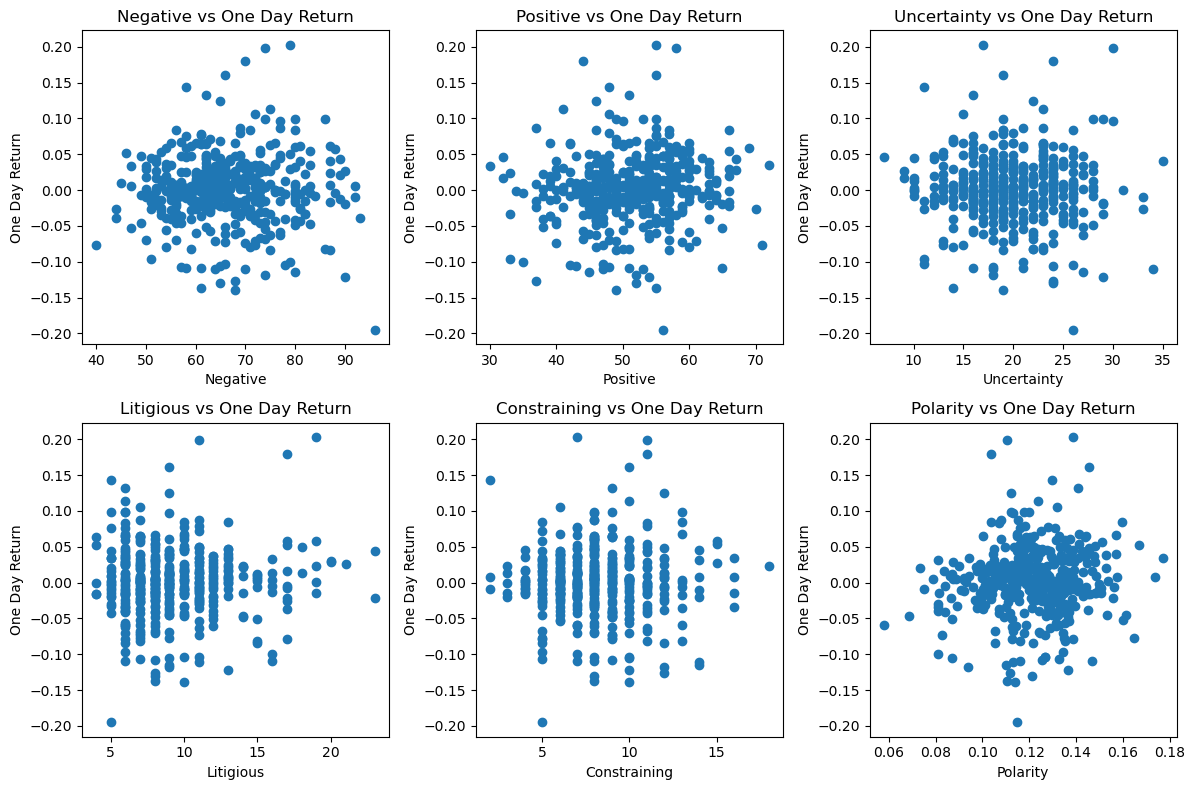

In [57]:
# Define the features and their corresponding labels
features = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'Polarity']
labels = ['Negative', 'Positive', 'Uncertainty', 'Litigious', 'Constraining', 'Polarity']

# Create scatter plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    ax.scatter(df[feature], df['One Day Return'])
    ax.set_xlabel(labels[i])
    ax.set_ylabel('One Day Return')
    ax.set_title(f'{labels[i]} vs One Day Return')

plt.tight_layout()
plt.show()


In [38]:
# Prepare the independent variables
X = df[['negative', 'positive', 'uncertainty', 'litigious', 'constraining']].values

# Prepare the dependent variable
y = df['One Day Return'].values

# Create an instance of the LinearRegression model
regression = LinearRegression()

# Fit the model to the data
regression.fit(X, y)

# Retrieve the coefficients and intercept
coefficients = regression.coef_
intercept = regression.intercept_

# Obtain predictions for linear regression
y_pred_linear = regression.predict(X)

# Calculate MSE for linear regression
mse_linear = mean_squared_error(y, y_pred_linear)

# Calculate RMSE for linear regression
rmse_linear = np.sqrt(mse_linear)

# Calculate MAE for linear regression
mae_linear = mean_absolute_error(y, y_pred_linear)

# Calculate R-squared for linear regression
r2_linear = r2_score(y, y_pred_linear)

# Print the coefficients and intercept
print('Coefficients:', coefficients)
print('Intercept:', intercept)

# Print the evaluation metrics
print('Linear Regression MSE:', mse_linear)
print('Linear Regression RMSE:', rmse_linear)
print('Linear Regression MAE:', mae_linear)
print('Linear Regression R-squared:', r2_linear)

Coefficients: [ 0.00010162  0.00052652 -0.00043088  0.00062328  0.00022142]
Intercept: -0.031312885144667596
Linear Regression MSE: 0.002365994877003035
Linear Regression RMSE: 0.048641493367319995
Linear Regression MAE: 0.03456973172263542
Linear Regression R-squared: 0.009055027837521878


In [39]:
# Prepare the independent variables
X = df[['negative', 'positive', 'uncertainty', 'litigious', 'constraining']].values

# Prepare the dependent variable
y = df['One Day Return'].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the XGBoost regressor
xgb_reg = xgb.XGBRegressor()

# Fit the model on the training data
xgb_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('R-squared:', r2)

MSE: 0.004091055137740303
RMSE: 0.06396135659709153
MAE: 0.046535008998767356
R-squared: -1.52888863114827
